# General debt projection v.4.2

The objetive of debt projection, as its name says, is to make a projection or aproximation of the payment needed to liquidate the debt during the current month. The projection works based on the behavior of similar debts during recent months. Particularly, the payment projection will be based on the behavior of debts of the same bank and with the same deliquency time during the last twelve months. The projection will be presented as a discount over the actual balance of the debt. As we don't know the actual balance of the debt, we will need to make an aproximation of that too.

We have two metods for discount projection. Noah method uses the last discount the debt got and projects the new discount as the next discount on the list. The list is created based on the behavior of the debts. Percentil method uses the 15% percentil discount curve for each deliquency time and projects the new discount as the corresponding discount depending on the created curve. Noah method will be the main method, while percentil method will only be used on debts with no history of discounts.

The process of projection will follow the next steps:

1. Establishing parameters for the algorithm.
2. Import and clean data.
3. Actual balance aproximation.
4. Logarithmic discount curve adjustment.
5. Use of the curves for discount projection
    1. Noah Method.
    2. Percentil Metod.
6. Saving results.

## Parameters of the algorithm

In [8]:
# Libraries
import pandas as pd # for dataframes
import numpy as np # for numerical processes
import matplotlib.pyplot as plt # for graphs
from sklearn.metrics import mean_squared_error

In [9]:
# python settings
pd.set_option('display.max_columns', 100) # displays 100 columns on dataframes

In [10]:
# parameters
activities_source = r'BBVA_activities_jun23_may24.csv' # activities are the history of discounts
bins_source = r'BBVA_bins.csv' # bins indicate the interest rate of each debt
active_debts_source = r'BBVA_active_debts_01_07_2024.csv'
results_file_name = r'BBVA_cards_test_results.csv'
bank_input = 'card' # 'card' or 'loan' (only for BBVA and Santander, for other banks write False)
max_period = 18 #max period of interest grow
max_discount = 0.85 # max discount for projections
default_discount = 0.75 # default discount for bigger deliquencies than curve size

In [11]:
# advanced parameters
date_format = '%Y-%m-%d' # for formatting on date
default_interest_rate = 0.04
bigger_tolerance_rate = 3 # max times payment can be bigger than debt. bigger will be considered a mistake.
max_discount_tolerance = 0.98 #max discount. bigger will be considered a mistake.
curve_size = 20 # deliq months to consider in curves
percentile_1 = 15 # smaller percentil for percentil method
percentile_2 = 50 # bigger percentil for Noah metod
today = np.datetime64('today') #analysis date

In [12]:
# gradient descent method parameters
a0 = [0.4,10] # initial parameters
a1 = a0 + np.random.rand(2)*[0.1,1] # initial parameters
iterations = 100
step = 0.01
parameter_range = 4 # discrete steps to try for the beggining of the log function

## Data

In [13]:
#import data
activities = pd.read_csv(activities_source)
bins = pd.read_csv(bins_source)
active_debts = pd.read_csv(active_debts_source)

In [14]:
# clean activities
activities.inicio_programa = pd.to_datetime(activities.inicio_programa,format=date_format,errors='coerce') # errors in cast will be NaT
activities.ultimo_pago = pd.to_datetime(activities.ultimo_pago,format=date_format,errors='coerce')
activities.executed_date = pd.to_datetime(activities.executed_date,format=date_format,errors='coerce')
activities[['bank_reference','debt_id','banco','num_tarjeta']] = activities[['bank_reference','debt_id','banco','num_tarjeta']].astype(str) #simultaneous cast
activities.dropna(inplace=True) #drop rows with null or NaT values
activities.reset_index(drop = True,inplace=True)

In [15]:
#clean Bins
bins['Bin'] = bins['Bin'].astype(str).str.zfill(6) # zfill ensures data has 6 digits, fills with zeros.
bins.drop_duplicates('Bin',inplace=True)
bins.reset_index(drop = True,inplace=True)

In [16]:
# clean active debts
active_debts.beginning_program = pd.to_datetime(active_debts.beginning_program,format = date_format,errors = 'coerce')
active_debts.last_payment_date = pd.to_datetime(active_debts.last_payment_date,format = date_format,errors = 'coerce')
active_debts[['bank_reference','debt_id','num_tarjeta']] = active_debts[['bank_reference','debt_id','num_tarjeta']].astype(str)
active_debts.dropna(inplace=True)
active_debts.reset_index(drop = True,inplace=True)

## Balance Aproximation

In [22]:
if bank_input: # 'if' reads anything thats not 'False' or 0 as True
    cards = activities.num_tarjeta.str.replace(r'\D','',regex=True) # regex help us filter only numeric values
    cards_len = cards.str.len()
    activities['bank_type'] = np.where((cards_len >= 15)&(cards_len <= 17), 'card','loan') # cards have 16 digits
    activities['Bin'] = cards.str[:6]
    activities = activities[activities.bank_type == bank_input].reset_index(drop = True) # reset index help us keep an ordered dataframe
else:
    cards = activities.num_tarjeta.str.replace(r'\D','',regex=True)
    activities['Bin'] = cards.str[:6]

In [23]:
activities = pd.merge(activities, bins, on = 'Bin', how = 'left') # we merge to find interest rate

In [24]:
activities.tasa = activities.tasa.fillna(default_interest_rate) # we fill with default interest rate bins not find
#we use the date formula [(Y2-Y1)*12 + M2-M1] to calculate deliquencies
activities['deliq_beginning_prog'] = (activities.inicio_programa.dt.year - activities.ultimo_pago.dt.year)*12 + activities.inicio_programa.dt.month - activities.ultimo_pago.dt.month
activities.deliq_beginning_prog = np.where(activities.deliq_beginning_prog < 0, 0, activities.deliq_beginning_prog)
activities['deliq_act'] = (activities.executed_date.dt.year - activities.ultimo_pago.dt.year)*12 + activities.executed_date.dt.month - activities.ultimo_pago.dt.month
activities.drop(activities[activities.deliq_act <0].index,inplace=True) # we drop negative periods as there must be a payment after the discount
#aux_balance help us to know the deliquency months passed from last record
activities['aux_balance'] = np.where(activities.deliq_beginning_prog > max_period, 0,
                                     np.where(activities.deliq_act > max_period, max_period - activities.deliq_beginning_prog,
                                              activities.deliq_act - activities.deliq_beginning_prog))
# we use the compound interest formula for balance
activities['balance'] = activities.deuda_resuelve*(1 + activities.tasa)**(activities.aux_balance)
activities['real_discount'] = 1-activities.pago_a_bancos/activities.balance
# we filter activities to avoid incongruent payments
activities.drop(activities[activities.deuda_resuelve*bigger_tolerance_rate < activities.pago_a_bancos].index, inplace = True)
activities.drop(activities[activities.real_discount > max_discount_tolerance].index,inplace=True)
activities.reset_index(drop = True,inplace=True)

In [25]:
# check if the information is sufficient a.k.a. we have at least one row for each deliquency
sufficient = pd.Series(range(curve_size)).isin(pd.Series(activities['deliq_act'].unique())).all()

In [26]:
if sufficient:
    #if the info is sufficient, we do balance aproximation of active debts
    if bank_input:
        cards = active_debts.num_tarjeta.str.replace(r'\D','',regex=True)
        cards_len = cards.str.len()
        active_debts['bank_type'] = np.where((cards_len >= 15)&(cards_len <= 17), 'card','loan')
        active_debts['Bin'] = cards.str[:6]
        active_debts = active_debts[active_debts.bank_type == bank_input].reset_index(drop = True)
    else:
        cards = active_debts.num_tarjeta.str.replace(r'\D','',regex=True)
        active_debts['Bin'] = cards.str[:6]

In [27]:
if sufficient:
    active_debts = pd.merge(active_debts,bins,on = 'Bin',how = 'left')

In [28]:
if sufficient:
    active_debts.tasa = active_debts.tasa.fillna(default_interest_rate)
    active_debts['deliq_beginning_prog'] = (active_debts.beginning_program.dt.year-active_debts.last_payment_date.dt.year)*12 + active_debts.beginning_program.dt.month - active_debts.last_payment_date.dt.month
    active_debts.deliq_beginning_prog = np.where(active_debts.deliq_beginning_prog < 0, 0, active_debts.deliq_beginning_prog)
    today = pd.to_datetime(today)
    active_debts['deliq_today'] = (today.year - active_debts.last_payment_date.dt.year)*12 + today.month - active_debts.last_payment_date.dt.month
    active_debts['aux_balance'] = np.where(active_debts.deliq_beginning_prog > max_period, 0,
                                           np.where(active_debts.deliq_today > max_period, max_period - active_debts.deliq_beginning_prog,
                                                    active_debts.deliq_today - active_debts.deliq_beginning_prog))
    active_debts['balance'] = active_debts.deuda_resuelve*(1+active_debts.tasa)**(active_debts.aux_balance)

## Curve Adjustment

### Gradent Descent Method

we'll use gradent descent metod to make an adjusted logarithmic curve that passess through the percentil points

In [29]:
#gradient descent function
if sufficient:
    def grad_desc(f,x0,x1,iterations,f_step):
        # this is the gradent descent method for R^2 -> R functions that uses
        # numerical aproximations of the derivate of the function.
        xii = np.array(x0) # numpy arrays are better for math ops
        xjj = np.array(x1) # j = i + 1
        it = 0
        while it < iterations and any(xii != xjj):
            xji = np.array([xjj[0],xii[1]])
            xij = np.array([xii[0],xjj[1]])
            if xjj[0] == xii[0]:
                df_dx = 0
            else:
                df_dx = (f(xji)-f(xii)) / (xjj[0]-xii[0])
            if xjj[1] == xii[1]:
                df_dy = 0
            else:
                df_dy = (f(xij)-f(xii)) / (xjj[1]-xii[1])
            mov = np.array([df_dx,df_dy]) * (-f_step)
            xii = xjj
            xjj = xjj + mov
            it = it + 1
        return xjj,f(xjj)

### Curve Adjustment

In [30]:
if sufficient:
    c1, c2 = np.zeros(curve_size), np.zeros(curve_size) # initialize adjusted curves
    # basic percentile assignation to the curves
    for month in range(1,curve_size):
        c1[month] = np.percentile(activities[activities.deliq_act == month].real_discount,percentile_1)
        c2[month] = np.percentile(activities[activities.deliq_act == month].real_discount,percentile_2)
    #finding ideal parameters for the curves
    for curve in [c1,c2]:
        for log_step in range(parameter_range):
            # f is the logarithmic function we will use
            def f(a,x):
                if (x-log_step)*a[1] <= 0:
                    res = 0
                else:
                    res = max(0,a[0]*np.log((x-log_step)*a[1]))
                return res
            # we use Mean Squared Error to evaluate error magnitude
            def MSE(a): return mean_squared_error([f(a,x) for x in range(curve_size)],curve)
            # we use grad desc to find optimal parameters
            a_candidate,f_candidate = grad_desc(MSE,a0,a1,iterations,step)
            # if we dont have an optimal value yet, use the first one
            try:
                if f_candidate < f_star:
                    a_star,f_star,log_step_star = a_candidate,f_candidate,log_step
            except:
                a_star,f_star,log_step_star = a_candidate,f_candidate,log_step
        def f(a,x):
            if (x-log_step_star)*a[1] <= 0:
                res = 0
            else:
                res = max(0,a[0]*np.log((x-log_step_star)*a[1]))
            return res
        if all(curve == c1):
            c1_adjusted = pd.DataFrame([f(a_star,x) for x in range(curve_size)],columns=['discount'])
        else:
            c2_adjusted = pd.DataFrame([f(a_star,x) for x in range(curve_size)],columns=['discount'])
        del f_star # we delete it so its not saved for the next loop

## Discount Projection

In [31]:
# we create a dataframe 'debts' to filter info by debt
if sufficient:
    debts = activities.sort_values(['debt_id','executed_date'],ascending=[True,False]).drop_duplicates(["debt_id"]).copy()
    debts = debts[['bank_reference','debt_id','ultimo_pago','deliq_beginning_prog','deuda_resuelve','tasa','real_discount','pago_a_bancos']].reset_index(drop = True)
    debts.rename(columns = {'real_discount':'last_discount','pago_a_bancos':'last_payment'},inplace=True)
    debts['deliq_today'] = (today.year - debts.ultimo_pago.dt.year)*12 + today.month - debts.ultimo_pago.dt.month
    debts['aux_balance_today'] = np.where(debts.deliq_beginning_prog > max_period, 0,
                                    np.where(debts.deliq_today > max_period, max_period - debts.deliq_beginning_prog,
                                             debts.deliq_today - debts.deliq_beginning_prog))
    debts["balance_today"] = debts.deuda_resuelve*(1+debts.tasa)**(debts.aux_balance_today)
    #Now we apply Noah algorithm
    for indx in debts.index:
        if debts.loc[indx,'last_discount'] > max_discount:
            debts.loc[indx,'projected_discount'] = max_discount
        else:
            debts.loc[indx,'projected_discount'] = c2_adjusted.discount[c2_adjusted.discount > debts.loc[indx,'last_discount']].head(1).values
    debts['projected_payment'] = debts.balance_today * (1-debts.projected_discount)
    # as a final step, we will load only payments as good as the last one
    debts['load_adjustment'] = np.where(debts.projected_payment < debts.last_payment,
                                       debts.projected_payment, debts.last_payment)
    debts['quality'] = 1 #all debts projected with Noah method will have quality 1

In [32]:
# for the active debts with no history, well use the percentil method
if sufficient:
    results = pd.merge(active_debts[['bank_reference','debt_id','bank_type','deliq_today','deuda_resuelve','balance']],debts[['debt_id','projected_discount','load_adjustment','quality']],on='debt_id',how='left')

In [41]:
if sufficient:
    for indx in results[results.isna().any(axis=1)].index:
        if results.loc[indx,'deliq_today'] >= curve_size:
            results.loc[indx,'projected_discount'] = default_discount
        else:
            results.loc[indx,'projected_discount'] = c1_adjusted.discount[results.loc[indx,'deliq_today']]
        results.loc[indx,'load_adjustment'] = results.loc[indx,'balance'] * (1-results.loc[indx,'projected_discount'])
        results.loc[indx,'quality'] = 2
# we drop discounts that are greater than DB
results.drop(results[results.load_adjustment >= results.deuda_resuelve].index).reset_index(drop = True, inplace = True)

## Saving Results

In [43]:
if sufficient:
    results.to_csv(results_file_name)
else:
    print('Error: Not Enough Info')
    pd.DataFrame(columns = ['bank_reference','debt_id','load_adjustment','quality']).to_csv(results_file_name)
    pd.DataFrame(columns = ['discount']).to_csv(results_file_name)

## Plots and Sample

(0.0, 50.0)

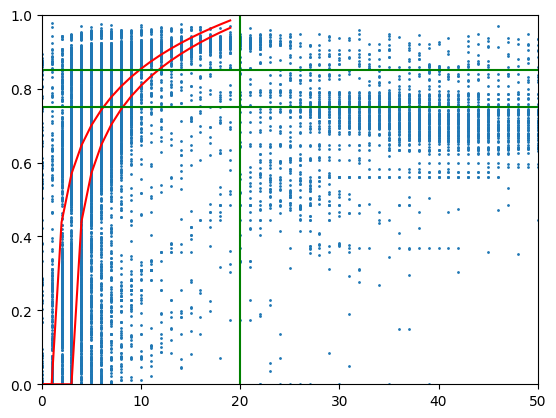

In [45]:
plt.scatter(activities.deliq_act,activities.real_discount,s=1)
plt.plot(c2_adjusted,color='red')
plt.plot(c1_adjusted,color='red')
plt.axhline(y=default_discount, color ='green')
plt.axhline(y=max_discount, color ='green')
plt.axvline(x=curve_size, color ='green')
plt.ylim(0,1)
plt.xlim(0,50)

In [46]:
results.sample(10)

,bank_reference,debt_id,bank_type,deliq_today,deuda_resuelve,balance,projected_discount,load_adjustment,quality
521,10103796070,1565601,card,1,140197.00,145454.387500,0.000000,145454.387500,2.0
4526,10103763113,1529163,card,3,31164.43,33545.587230,0.000000,33545.587230,2.0
2213,10103228820,964495,card,30,47236.34,76229.243513,0.569377,32826.053148,1.0
724,10103426370,1165586,card,16,71414.24,128704.729117,0.850000,10429.000000,1.0
427,10103786482,1554295,card,2,44910.26,46594.394750,0.000000,46594.394750,2.0
4672,10103768751,1535005,card,2,136065.00,146461.216406,0.000000,146461.216406,2.0
3367,10103713400,1467902,card,4,36858.00,42705.536998,0.439481,23937.251517,2.0
3420,10103748696,1513016,card,4,13457.41,15028.851742,0.439481,8423.952242,2.0
3795,10103732862,1495748,card,11,70118.18,78305.983960,0.850000,6515.000000,1.0
5063,10103777548,1544115,card,2,22831.23,23687.401125,0.000000,23687.401125,2.0
